In [38]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np
import os


=== Case 1: BG0001_L_siphon_lab.vtk ===
Max curvature index: 17, value = 0.595592
Start index: 14, curvature = 0.534295 (>= thr? True)
End index: 20, curvature = 0.477423 (>= thr? True)
Threshold (max × 0.8) = 0.476474
Segment point count: 7

=== Case 2: BG0012_R_siphon_lab.vtk ===
Max curvature index: 17, value = 1.009680
Start index: 14, curvature = 0.809412 (>= thr? True)
End index: 20, curvature = 0.814655 (>= thr? True)
Threshold (max × 0.8) = 0.807744
Segment point count: 7

=== Case 3: BG0017_R_siphon_lab.vtk ===
Max curvature index: 18, value = 1.045280
Start index: 16, curvature = 0.916524 (>= thr? True)
End index: 20, curvature = 0.926161 (>= thr? True)
Threshold (max × 0.8) = 0.836224
Segment point count: 5

=== Case 4: BG0011_R_siphon_lab.vtk ===
Max curvature index: 17, value = 1.492590
Start index: 15, curvature = 1.243320 (>= thr? True)
End index: 18, curvature = 1.459370 (>= thr? True)
Threshold (max × 0.8) = 1.194072
Segment point count: 4


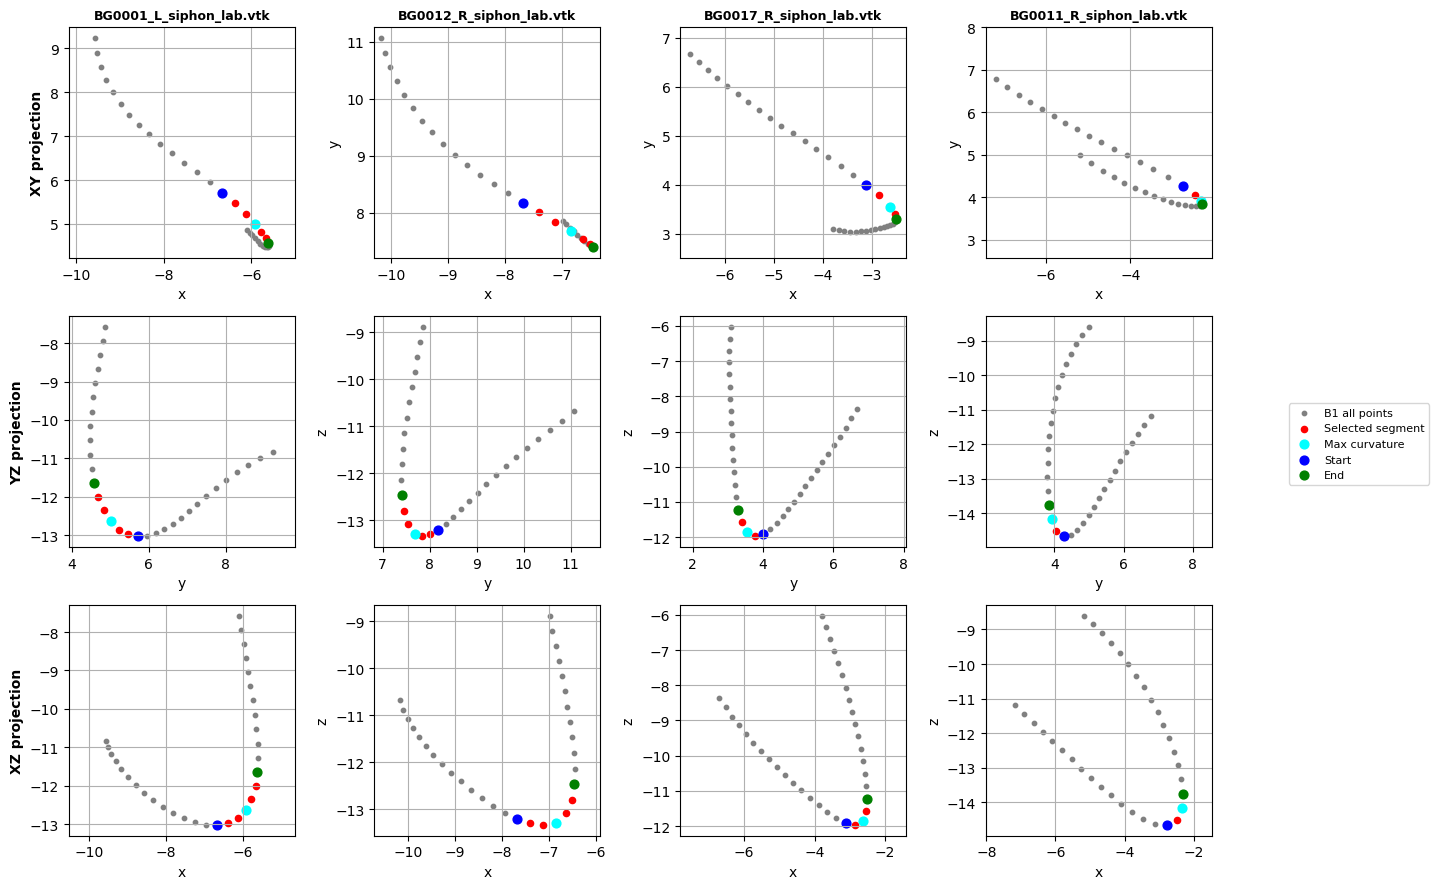

In [26]:
# === Parameters ===
DROP_RATIO = 0.8

# === Load multiple datasets ===
input_paths = [
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk", # U type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0012_R_siphon_lab.vtk", # V type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0017_R_siphon_lab.vtk", # C type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0011_R_siphon_lab.vtk"  # U type
]

# === Adaptive segment extraction ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    threshold = drop_ratio * max_val

    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx] > threshold:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx] > threshold:
        right_idx += 1

    # 校正到仍满足 >= threshold 的端点
    if curv[left_idx] < threshold and left_idx < max_idx:
        left_idx += 1
    if curv[right_idx] < threshold and right_idx > max_idx:
        right_idx -= 1

    seg_pts = pts[left_idx:right_idx + 1]
    return seg_pts, max_idx, left_idx, right_idx, max_val, threshold

# === 3×4 subplot grid ===
fig, axes = plt.subplots(3, 4, figsize=(14, 9))
titles_row = ["XY projection", "YZ projection", "XZ projection"]
coords = [(0, 1), (1, 2), (0, 2)]

# 用于创建全局图例的“代理句柄”
handles = []
labels = []

# === Loop through all cases ===
for col, path in enumerate(input_paths):
    centerline = pv.read(path)
    points = centerline.points
    labels_arr = centerline["lab"]
    curvature = centerline["curvature"]

    bend1_pts = points[labels_arr == 1]
    bend1_curv = curvature[labels_arr == 1]

    seg_pts, max_idx, left_idx, right_idx, max_val, threshold = extract_adaptive_segment(
        bend1_pts, bend1_curv, DROP_RATIO
    )

    # === 打印你要的详细信息 ===
    filename = os.path.basename(path)
    print(f"\n=== Case {col+1}: {filename} ===")
    print(f"Max curvature index: {max_idx}, value = {bend1_curv[max_idx]:.6f}")
    print(f"Start index: {left_idx}, curvature = {bend1_curv[left_idx]:.6f} (>= thr? {bend1_curv[left_idx] >= threshold})")
    print(f"End index: {right_idx}, curvature = {bend1_curv[right_idx]:.6f} (>= thr? {bend1_curv[right_idx] >= threshold})")
    print(f"Threshold (max × {DROP_RATIO}) = {threshold:.6f}")
    print(f"Segment point count: {len(seg_pts)}")

    # --- 3 projections (XY / YZ / XZ) across rows ---
    for row, (i, j) in enumerate(coords):
        ax = axes[row, col]

        s1 = ax.scatter(bend1_pts[:, i], bend1_pts[:, j], s=10, color="gray", label="B1 all points")
        s2 = ax.scatter(seg_pts[:, i], seg_pts[:, j], s=20, color="red", label="Selected segment")
        s3 = ax.scatter(bend1_pts[max_idx, i], bend1_pts[max_idx, j], s=40, color="cyan", label="Max curvature")
        s4 = ax.scatter(bend1_pts[left_idx, i], bend1_pts[left_idx, j], s=40, color="blue", label="Start")
        s5 = ax.scatter(bend1_pts[right_idx, i], bend1_pts[right_idx, j], s=40, color="green", label="End")

        if row == 0 and col == 0:  # 只在第一个子图收集图例
            handles = [s1, s2, s3, s4, s5]
            labels = [h.get_label() for h in handles]

        ax.set_xlabel(["x", "y", "z"][i])
        ax.set_ylabel(["x", "y", "z"][j])
        ax.axis("equal")
        ax.grid(True)
        if row == 0:
            ax.set_title(filename, fontsize=9, fontweight="bold")
        if col == 0:
            ax.set_ylabel(titles_row[row], fontsize=10, fontweight="bold")

# === 调整布局，使右侧空出位置放图例 ===
plt.tight_layout(rect=[0, 0, 0.88, 1])  # 右边预留空间
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.92, 0.5), fontsize=8, frameon=True)

plt.show()



=== Case 1: BG0001_L_siphon_lab.vtk ===
Max curvature index: 17, value = 0.595592
Start index: 14, curvature = 0.534295 (>= thr? True)
End index: 20, curvature = 0.477423 (>= thr? True)
Threshold (max × 0.8) = 0.476474
Segment point count: 7

=== Case 2: BG0012_R_siphon_lab.vtk ===
Max curvature index: 17, value = 1.009680
Start index: 14, curvature = 0.809412 (>= thr? True)
End index: 20, curvature = 0.814655 (>= thr? True)
Threshold (max × 0.8) = 0.807744
Segment point count: 7

=== Case 3: BG0017_R_siphon_lab.vtk ===
Max curvature index: 18, value = 1.045280
Start index: 16, curvature = 0.916524 (>= thr? True)
End index: 20, curvature = 0.926161 (>= thr? True)
Threshold (max × 0.8) = 0.836224
Segment point count: 5

=== Case 4: BG0011_R_siphon_lab.vtk ===
Max curvature index: 17, value = 1.492590
Start index: 15, curvature = 1.243320 (>= thr? True)
End index: 18, curvature = 1.459370 (>= thr? True)
Threshold (max × 0.8) = 1.194072
Segment point count: 4


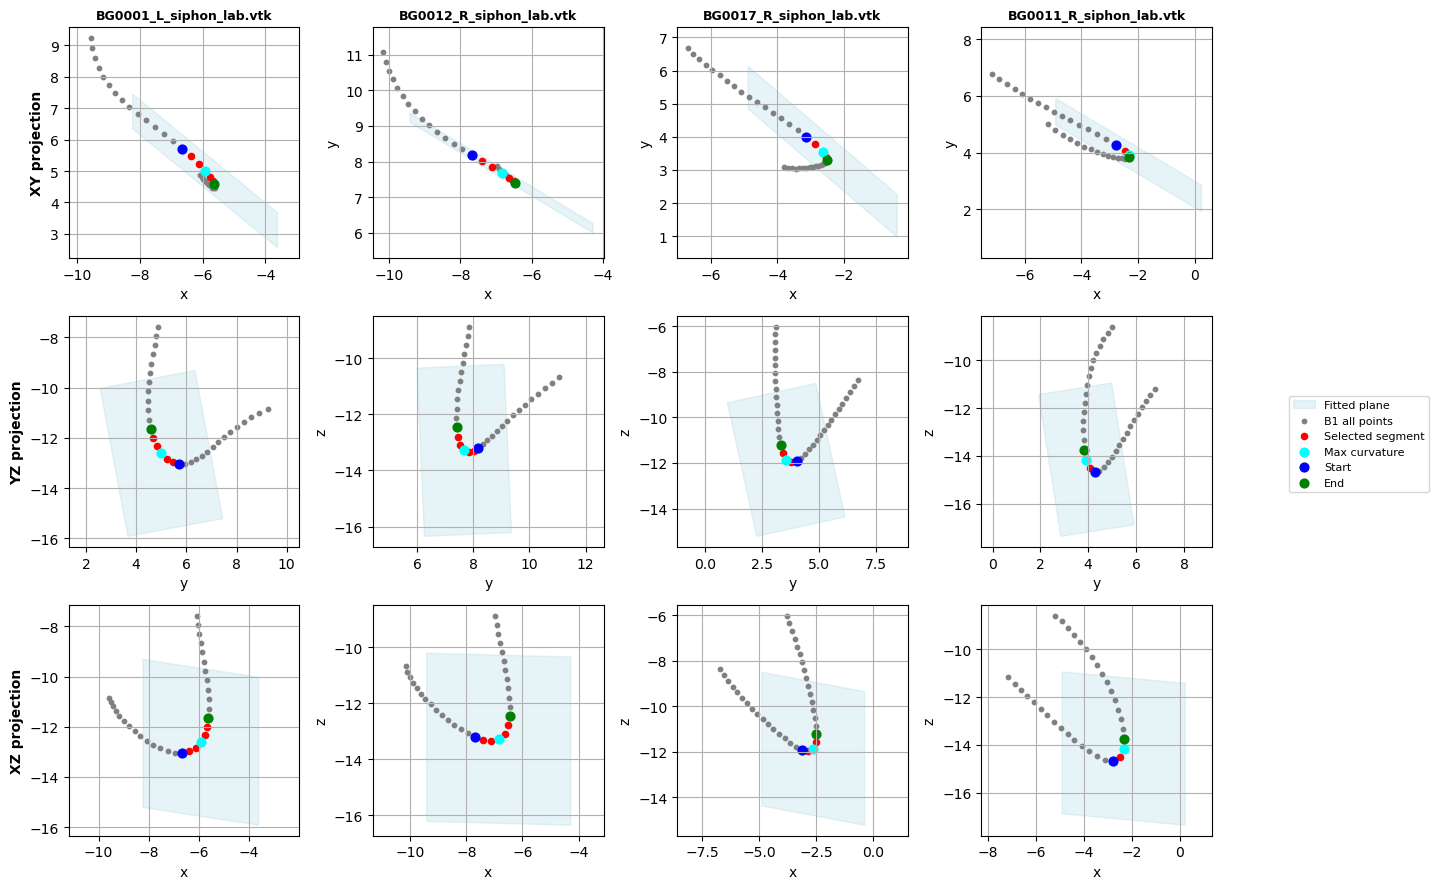

In [28]:
# === Parameters ===
DROP_RATIO = 0.8
PLANE_SIZE = 3  # 平面显示尺寸

# === Load multiple datasets ===
input_paths = [
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk", # U type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0012_R_siphon_lab.vtk", # V type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0017_R_siphon_lab.vtk", # C type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0011_R_siphon_lab.vtk"  # U type
]

# === Adaptive segment extraction ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    threshold = drop_ratio * max_val

    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx - 1] >= threshold:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx + 1] >= threshold:
        right_idx += 1

    seg_pts = pts[left_idx:right_idx + 1]
    return seg_pts, max_idx, left_idx, right_idx, max_val, threshold


# === Figure setup (3×4) ===
fig, axes = plt.subplots(3, 4, figsize=(14, 9))
titles_row = ["XY projection", "YZ projection", "XZ projection"]
coords = [(0, 1), (1, 2), (0, 2)]

# === 保存图例句柄 ===
handles, labels = [], []

# === Loop over 4 cases ===
for col, path in enumerate(input_paths):
    centerline = pv.read(path)
    points = centerline.points
    labels_arr = centerline["lab"]
    curvature = centerline["curvature"]

    bend1_pts = points[labels_arr == 1]
    bend1_curv = curvature[labels_arr == 1]

    seg_pts, max_idx, left_idx, right_idx, max_val, threshold = extract_adaptive_segment(bend1_pts, bend1_curv)
    curv_max = bend1_curv[max_idx]

    # === Plane fitting ===
    p_max = bend1_pts[max_idx]
    mean_pt = np.mean(seg_pts, axis=0)
    centered = seg_pts - mean_pt
    cov = np.dot(centered.T, centered)
    eigvals, eigvecs = np.linalg.eigh(cov)
    n = eigvecs[:, np.argmin(eigvals)]
    n /= np.linalg.norm(n)

    temp = np.array([1, 0, 0]) if abs(n[0]) < 0.9 else np.array([0, 1, 0])
    u = np.cross(n, temp); u /= np.linalg.norm(u)
    v = np.cross(n, u)

    plane_corners = np.array([
        p_max + PLANE_SIZE * ( u + v),
        p_max + PLANE_SIZE * (-u + v),
        p_max + PLANE_SIZE * (-u - v),
        p_max + PLANE_SIZE * ( u - v)
    ])

    filename = os.path.basename(path)
    print(f"\n=== Case {col+1}: {filename} ===")
    print(f"Max curvature index: {max_idx}, value = {curv_max:.6f}")
    print(f"Start index: {left_idx}, curvature = {bend1_curv[left_idx]:.6f} (>= thr? {bend1_curv[left_idx] >= threshold})")
    print(f"End index: {right_idx}, curvature = {bend1_curv[right_idx]:.6f} (>= thr? {bend1_curv[right_idx] >= threshold})")
    print(f"Threshold (max × {DROP_RATIO}) = {threshold:.6f}")
    print(f"Segment point count: {len(seg_pts)}")

    # === Draw three projections (each row) ===
    for row, (i, j) in enumerate(coords):
        ax = axes[row, col]

        s0 = ax.fill(plane_corners[:, i], plane_corners[:, j], color="lightblue", alpha=0.3, label="Fitted plane")
        s1 = ax.scatter(bend1_pts[:, i], bend1_pts[:, j], s=10, color="gray", label="B1 all points")
        s2 = ax.scatter(seg_pts[:, i], seg_pts[:, j], s=20, color="red", label="Selected segment")
        s3 = ax.scatter(bend1_pts[max_idx, i], bend1_pts[max_idx, j], s=40, color="cyan", label="Max curvature")
        s4 = ax.scatter(bend1_pts[left_idx, i], bend1_pts[left_idx, j], s=40, color="blue", label="Start")
        s5 = ax.scatter(bend1_pts[right_idx, i], bend1_pts[right_idx, j], s=40, color="green", label="End")

        if row == 0 and col == 0:
            handles = [s0[0], s1, s2, s3, s4, s5]
            labels = [h.get_label() for h in handles]

        ax.set_xlabel(["x", "y", "z"][i])
        ax.set_ylabel(["x", "y", "z"][j])
        ax.axis("equal")
        ax.grid(True)
        if row == 0:
            ax.set_title(filename, fontsize=9, fontweight="bold")
        if col == 0:
            ax.set_ylabel(titles_row[row], fontsize=10, fontweight="bold")

# === 调整布局 + 全局图例放右边 ===
plt.tight_layout(rect=[0, 0, 0.88, 1])  # 空出右边
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.92, 0.5), fontsize=8, frameon=True)

plt.show()


DropRatio | N_points |    MaxDist |   MeanDist |    StdDist
------------------------------------------------------------
     0.10 |       31 |   0.294285 |   0.137603 |   0.074380
     0.20 |       27 |   0.236353 |   0.104059 |   0.056680
     0.30 |       22 |   0.148250 |   0.064888 |   0.035941
     0.40 |       20 |   0.113991 |   0.050918 |   0.029675
     0.50 |       17 |   0.070880 |   0.034062 |   0.017575
     0.60 |       15 |   0.049965 |   0.025191 |   0.013036
     0.70 |       13 |   0.030357 |   0.016201 |   0.009105
     0.80 |        9 |   0.008599 |   0.005794 |   0.002569
     0.90 |        6 |   0.003367 |   0.002177 |   0.000895


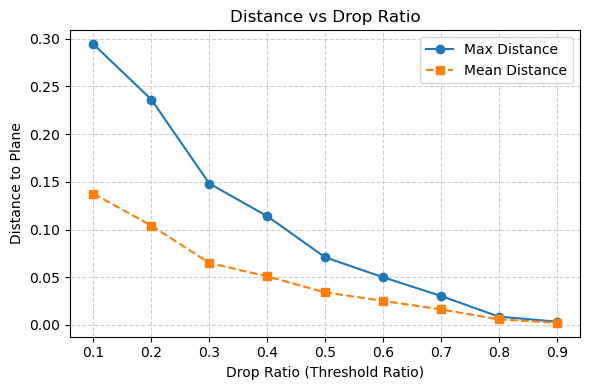

In [70]:
import pyvista as pv
import numpy as np

# === 参数 ===
FILE = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk"
DROP_RATIOS = np.arange(0.1, 1.0, 0.1)  # 0.1~0.9

# === 载入数据 ===
cl = pv.read(FILE)
pts_all = cl.points
lab = cl["lab"]
curv = cl["curvature"]

# 只取 B1 段
pts = pts_all[lab == 2]
k   = curv[lab == 2]

# === 选段函数 ===
def extract_segment(pts, k, drop_ratio):
    i_max = np.argmax(k)
    k_max = k[i_max]
    thr   = drop_ratio * k_max
    L = R = i_max
    while L > 0 and k[L-1] >= thr: L -= 1
    while R < len(k)-1 and k[R+1] >= thr: R += 1
    return pts[L:R+1], i_max, L, R, k_max, thr

# === 主循环 ===
results = []

for ratio in DROP_RATIOS:
    seg_pts, i_max, L, R, k_max, thr = extract_segment(pts, k, ratio)

    # 平面拟合
    mean_pt = np.mean(seg_pts, axis=0)
    X = seg_pts - mean_pt
    C = X.T @ X
    eigvals, eigvecs = np.linalg.eigh(C)
    n = eigvecs[:, np.argmin(eigvals)]
    n /= np.linalg.norm(n)

    # 垂直距离
    signed_dist = (seg_pts - mean_pt) @ n
    dist = np.abs(signed_dist)

    max_d = dist.max()
    mean_d = dist.mean()
    std_d = dist.std()

    results.append([ratio, len(seg_pts), max_d, mean_d, std_d])

# === 输出结果表格 ===
print(f"{'DropRatio':>9} | {'N_points':>8} | {'MaxDist':>10} | {'MeanDist':>10} | {'StdDist':>10}")
print("-" * 60)
for r, n, dmax, dmean, dstd in results:
    print(f"{r:9.2f} | {n:8d} | {dmax:10.6f} | {dmean:10.6f} | {dstd:10.6f}")

# === 可选：可视化曲线 ===
import matplotlib.pyplot as plt
ratios = [r[0] for r in results]
max_vals = [r[2] for r in results]
mean_vals = [r[3] for r in results]

plt.figure(figsize=(6,4))
plt.plot(ratios, max_vals, 'o-', label='Max Distance')
plt.plot(ratios, mean_vals, 's--', label='Mean Distance')
plt.xlabel('Drop Ratio (Threshold Ratio)')
plt.ylabel('Distance to Plane')
plt.title('Distance vs Drop Ratio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


共检测到 78 个 VTK 文件。


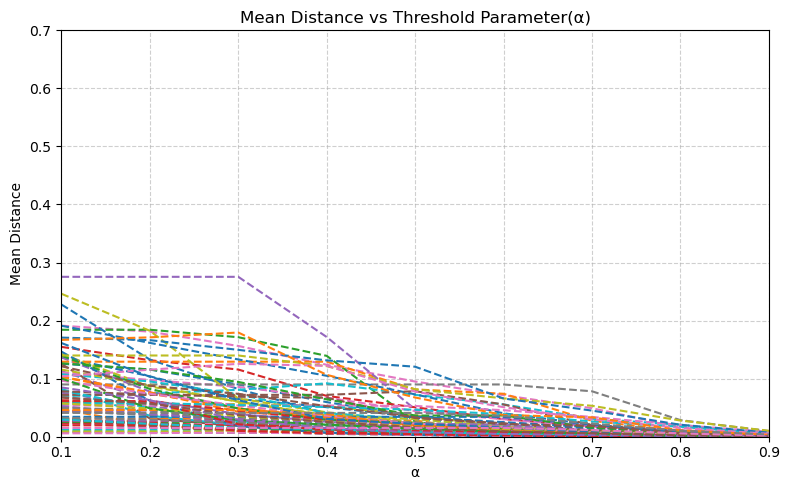

In [81]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# === 参数 ===
DIR = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)"
DROP_RATIOS = np.arange(0.1, 1.0, 0.1)  # 阈值 0.1 ~ 0.9

# === 曲率段提取函数 ===
def extract_segment(pts, k, drop_ratio):
    i_max = np.argmax(k)
    k_max = k[i_max]
    thr = drop_ratio * k_max
    L = R = i_max
    while L > 0 and k[L - 1] >= thr:
        L -= 1
    while R < len(k) - 1 and k[R + 1] >= thr:
        R += 1
    return pts[L:R + 1], i_max, L, R, k_max, thr

# === 单文件计算 ===
def analyze_file(vtk_path):
    cl = pv.read(vtk_path)
    pts_all = cl.points
    lab = cl["lab"]
    curv = cl["curvature"]

    # 合并 B1+B2 段
    pts = pts_all[lab == 2] 
    k = curv[lab == 2]

    results = []
    for ratio in DROP_RATIOS:
        seg_pts, i_max, L, R, k_max, thr = extract_segment(pts, k, ratio)

        # 平面拟合
        mean_pt = np.mean(seg_pts, axis=0)
        X = seg_pts - mean_pt
        C = X.T @ X
        eigvals, eigvecs = np.linalg.eigh(C)
        n = eigvecs[:, np.argmin(eigvals)]
        n /= np.linalg.norm(n)

        # 垂直距离
        signed_dist = (seg_pts - mean_pt) @ n
        dist = np.abs(signed_dist)

        max_d = dist.max()
        mean_d = dist.mean()
        results.append((ratio, len(seg_pts), max_d, mean_d))

    return results

# === 遍历目录 ===
vtk_files = sorted([f for f in os.listdir(DIR) if f.endswith(".vtk")])
summary = []

print(f"共检测到 {len(vtk_files)} 个 VTK 文件。")

for fname in vtk_files:
    path = os.path.join(DIR, fname)
    try:
        res = analyze_file(path)
        for ratio, n, dmax, dmean in res:
            summary.append({
                "File": fname,
                "DropRatio": ratio,
                "Points": n,
                "MaxDist": dmax,
                "MeanDist": dmean
            })
        #print(f"✔ 已处理: {fname}")
    except Exception as e:
        print(f"✘ 错误: {fname} -> {e}")

# === 汇总表 ===
df = pd.DataFrame(summary)
out_csv = os.path.join(DIR, "PlaneDistance_Summary.csv")
df.to_csv(out_csv, index=False)
#print(f"\n✅ 已输出结果表: {out_csv}")

# === 计算整体平均范围 ===
agg = df.groupby("File")[["MaxDist", "MeanDist"]].agg(["mean", "max", "min"])
#print("\n=== 每个文件的距离统计 ===")
#print(agg.round(6))

# === 可选: 画出各文件平均距离随Drop变化趋势 ===
plt.figure(figsize=(8, 5))
for file, sub in df.groupby("File"):
    plt.plot(sub["DropRatio"], sub["MeanDist"], '--', label=file[:10])
plt.xlabel("α")
plt.ylabel("Mean Distance")
plt.xlim(0.1,0.9)
plt.ylim(0,0.7)
plt.title("Mean Distance vs Threshold Parameter(α)")
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [55]:
# === Parameters ===
DROP_RATIO = 0.5
PLANE_SIZE = 3.5
ARROW_SCALE = 2.0
SPHERE_RADIUS = 0.2

# === Load data ===
input_path = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk"
centerline = pv.read(input_path)

points = centerline.points
labels = centerline["lab"]
curvature = centerline["curvature"]

# === Extract B1 region ===
bend1_pts = points[labels == 1]
bend1_curv = curvature[labels == 1]

# === Step 1: Select fitting segment ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx] > drop_ratio * max_val:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx] > drop_ratio * max_val:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx+1]
    return seg_pts, max_idx, left_idx, right_idx, max_val

seg_pts, max_idx, left_idx, right_idx, max_val = extract_adaptive_segment(bend1_pts, bend1_curv)

# === Step 2: Fit plane (Eq.10–16) ===
p_max = bend1_pts[max_idx]           # 平面过最大曲率点
mean_pt = np.mean(seg_pts, axis=0)
centered = seg_pts - mean_pt

cov = np.dot(centered.T, centered)
eigvals, eigvecs = np.linalg.eigh(cov)
n = eigvecs[:, np.argmin(eigvals)]
n = n / np.linalg.norm(n)

# === Step 3: Build rectangular plane ===
temp = np.array([1, 0, 0]) if abs(n[0]) < 0.9 else np.array([0, 1, 0])
u = np.cross(n, temp)
u /= np.linalg.norm(u)
v = np.cross(n, u)

plane_corners = np.array([
    p_max + PLANE_SIZE * ( u + v),
    p_max + PLANE_SIZE * (-u + v),
    p_max + PLANE_SIZE * (-u - v),
    p_max + PLANE_SIZE * ( u - v)
])
faces = [4, 0, 1, 2, 3]
plane_mesh = pv.PolyData(plane_corners, faces)

# === Step 4: Build visualization objects ===
arrow = pv.Arrow(start=p_max, direction=n, scale=ARROW_SCALE)
max_point = pv.Sphere(radius=SPHERE_RADIUS, center=p_max)

# === Step 5: Interactive rendering ===
pl = pv.Plotter(notebook=False)
pl.add_mesh(centerline, color="black", line_width=2, label="Centerline")
pl.add_points(bend1_pts, color="gray", point_size=8, label="B1 points")
pl.add_points(seg_pts, color="red", point_size=10, label="Selected segment")
pl.add_mesh(plane_mesh, color="lightblue", opacity=0.4, label="Fitted plane")
pl.add_mesh(max_point, color="cyan", label="Max curvature point")
pl.add_mesh(arrow, color="navy", label="Plane normal vector")

# 标记起点与终点
pl.add_mesh(pv.Sphere(radius=SPHERE_RADIUS, center=bend1_pts[left_idx]), color="blue", label="Start")
pl.add_mesh(pv.Sphere(radius=SPHERE_RADIUS, center=bend1_pts[right_idx]), color="green", label="End")

pl.add_legend()
pl.show()


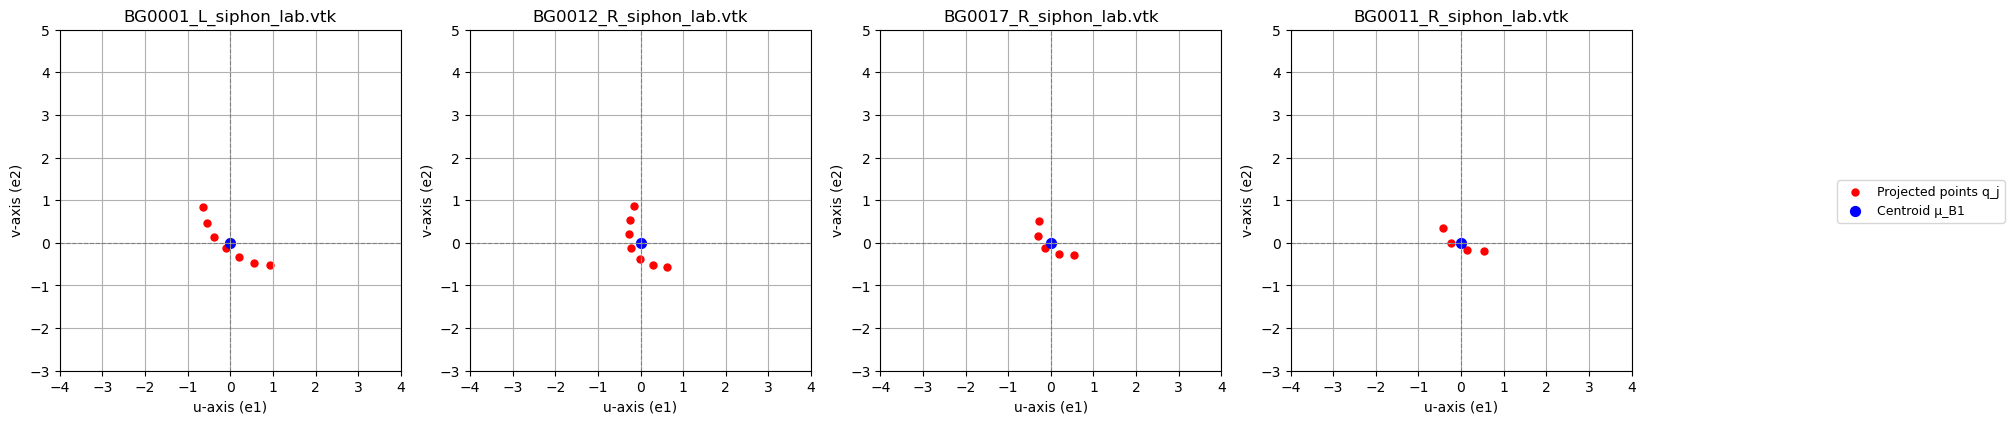

In [46]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np
import os

# === Parameters ===
DROP_RATIO = 0.8

# === 每个病例法向量方向控制 ===
# True → 翻转法向量方向（投影点上下或左右反转）
FLIP_NORMALS = {
    "BG0001_L": False,
    "BG0012_R": False,
    "BG0017_R": False,
    "BG0011_R": True
}

# === Input datasets ===
input_paths = [
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk", # U type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0012_R_siphon_lab.vtk", # V type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0017_R_siphon_lab.vtk", # C type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0011_R_siphon_lab.vtk"  # U type
]


# === 自适应高曲率段提取 ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    """Select points around curvature peak where curvature >= threshold."""
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    threshold = drop_ratio * max_val

    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx - 1] >= threshold:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx + 1] >= threshold:
        right_idx += 1

    seg_pts = pts[left_idx:right_idx + 1]
    return seg_pts, max_idx, left_idx, right_idx, max_val, threshold


# === Figure setup (1×4) ===
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for col, path in enumerate(input_paths):
    ax = axes[col]

    # === Load centerline data ===
    centerline = pv.read(path)
    points = centerline.points
    labels = centerline["lab"]
    curvature = centerline["curvature"]

    # === Extract B1 segment ===
    bend1_pts = points[labels == 1]
    bend1_curv = curvature[labels == 1]
    seg_pts, max_idx, left_idx, right_idx, max_val, threshold = extract_adaptive_segment(bend1_pts, bend1_curv)

    # === Fit local plane (PCA-based) ===
    mean_pt = np.mean(seg_pts, axis=0)
    centered = seg_pts - mean_pt
    cov = np.dot(centered.T, centered)
    eigvals, eigvecs = np.linalg.eigh(cov)
    n_B1 = eigvecs[:, np.argmin(eigvals)]
    n_B1 /= np.linalg.norm(n_B1)

    # === 控制法向量方向 ===
    case_id = os.path.basename(path).split("_siphon")[0]
    if FLIP_NORMALS.get(case_id, False):
        n_B1 = -n_B1

    # === Project points to plane ===
    proj_points_3d = np.array([
        p - np.dot(p - mean_pt, n_B1) * n_B1 for p in seg_pts
    ])

    # === Define local axes and get (u, v) ===
    temp = np.array([1, 0, 0]) if abs(n_B1[0]) < 0.9 else np.array([0, 1, 0])
    e1 = np.cross(n_B1, temp)
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(n_B1, e1)
    e2 /= np.linalg.norm(e2)

    u_v_coords = np.array([[np.dot(q - mean_pt, e1), np.dot(q - mean_pt, e2)] for q in proj_points_3d])

    # === Visualization ===
    ax.scatter(u_v_coords[:, 0], u_v_coords[:, 1], s=25, color="red", label="Projected points q_j")
    ax.scatter(0, 0, s=50, color="blue", label="Centroid μ_B1")
    ax.set_xlabel("u-axis (e1)")
    ax.set_ylabel("v-axis (e2)")
    ax.set_title(os.path.basename(path))
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

    # === Fix the coordinate range ===
    ax.set_xlim(-4, 4)
    ax.set_ylim(-3, 5)
    ax.axhline(0, color="gray", linewidth=0.8, linestyle='--')
    ax.axvline(0, color="gray", linewidth=0.8, linestyle='--')

# === Legend (shared) ===
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, frameon=True)

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()



=== BG0001_L_siphon_lab.vtk ===
[SVD          ] Center=(1.097683, 0.823659), Radius=1.860323
[QR           ] Center=(1.097683, 0.823659), Radius=1.860323
[Gauss–Newton ] Center=(1.104465, 0.827778), Radius=1.865847

=== BG0012_R_siphon_lab.vtk ===
[SVD          ] Center=(0.587421, 0.333125), Radius=1.106947
[QR           ] Center=(0.587421, 0.333125), Radius=1.106947
[Gauss–Newton ] Center=(0.602266, 0.337725), Radius=1.114859

=== BG0017_R_siphon_lab.vtk ===
[SVD          ] Center=(0.394204, 0.351261), Radius=1.032663
[QR           ] Center=(0.394204, 0.351261), Radius=1.032663
[Gauss–Newton ] Center=(0.406992, 0.369417), Radius=1.040328

=== BG0011_R_siphon_lab.vtk ===
[SVD          ] Center=(0.236252, 0.837956), Radius=1.205818
[QR           ] Center=(0.236252, 0.837956), Radius=1.205818
[Gauss–Newton ] Center=(0.257641, 0.931317), Radius=1.273712


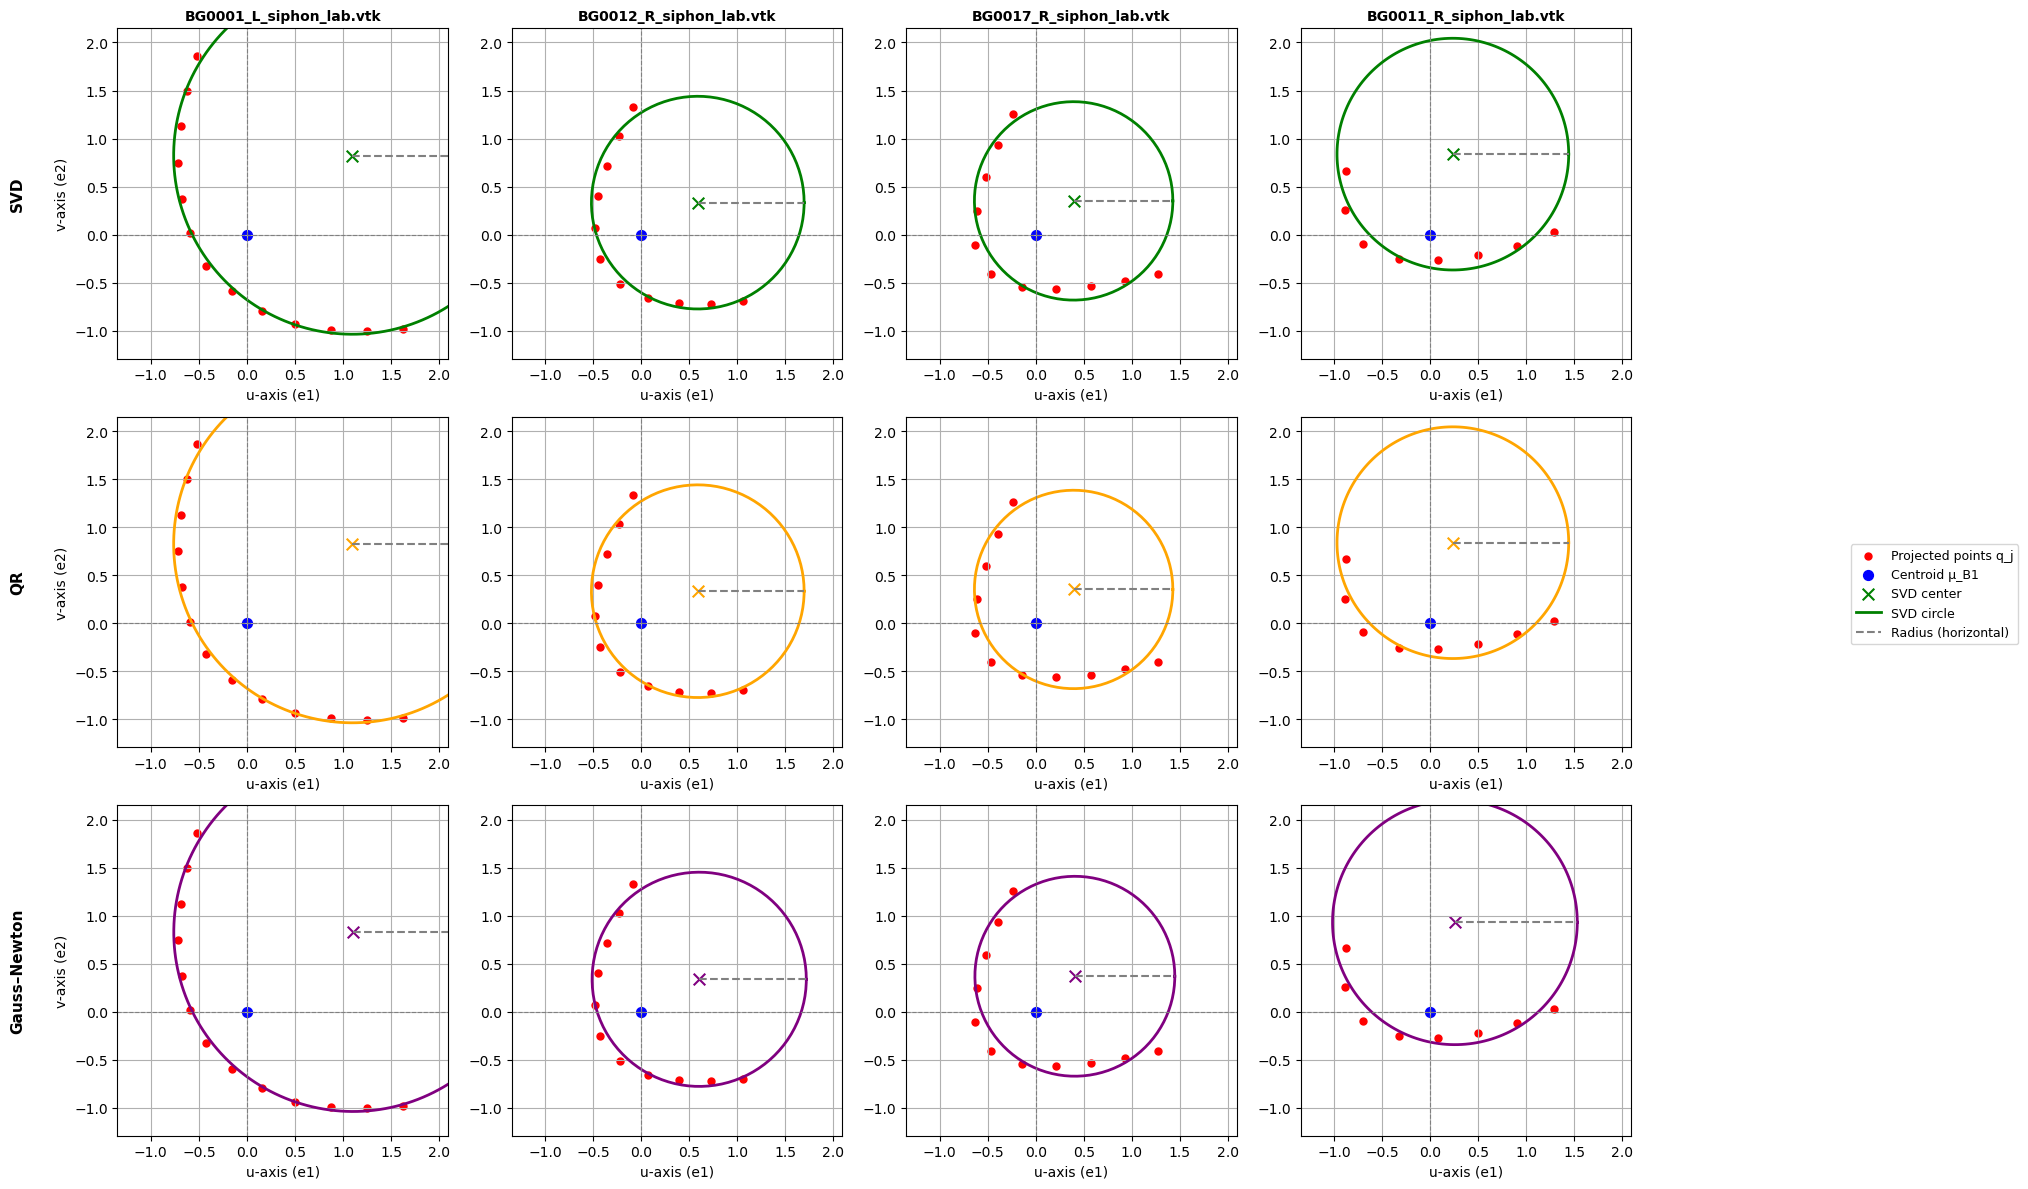

In [22]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np
import os

# === Parameters ===
DROP_RATIO = 0.5

# === Input datasets ===
input_paths = [
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk", # U type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0012_R_siphon_lab.vtk", # V type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0017_R_siphon_lab.vtk", # C type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0011_R_siphon_lab.vtk"  # U type
]

# === Algebraic circle fitting (SVD-based lstsq) ===
def fit_circle_algebraic(points_2d):
    x = points_2d[:, 0]
    y = points_2d[:, 1]
    A = np.c_[x, y, np.ones_like(x)]
    b = -(x**2 + y**2)
    coeff, _, _, _ = np.linalg.lstsq(A, b, rcond=None)  # SVD-based
    a, b_, c = coeff
    xc = -a / 2
    yc = -b_ / 2
    r = np.sqrt((a**2 + b_**2) / 4 - c)
    return xc, yc, r

# === QR decomposition least-squares ===
def fit_circle_qr(points_2d):
    x = points_2d[:, 0]
    y = points_2d[:, 1]
    A = np.c_[x, y, np.ones_like(x)]
    b = -(x**2 + y**2)
    Q, R = np.linalg.qr(A)
    coeff = np.linalg.solve(R, Q.T @ b)         # 解 Rθ = Qᵀb
    a, b_, c = coeff
    xc = -a / 2
    yc = -b_ / 2
    r = np.sqrt((a**2 + b_**2) / 4 - c)
    return xc, yc, r

# === Gauss–Newton refinement ===
def fit_circle_refine(points_2d, init_params=None, max_iter=100, tol=1e-10, lam=1e-6):
    x = points_2d[:, 0].astype(float)
    y = points_2d[:, 1].astype(float)
    if init_params is None:
        xc = np.mean(x); yc = np.mean(y)
        r = np.mean(np.sqrt((x - xc)**2 + (y - yc)**2))
    else:
        xc, yc, r = init_params

    last_cost = np.inf
    for _ in range(max_iter):
        Ri = np.sqrt((x - xc)**2 + (y - yc)**2)
        Ri = np.where(Ri < 1e-12, 1e-12, Ri)    # 避免除零
        residuals = Ri - r
        J = np.c_[ -(x - xc) / Ri, -(y - yc) / Ri, -np.ones_like(Ri) ]
        H = J.T @ J + lam * np.eye(3)
        g = J.T @ residuals
        delta = -np.linalg.solve(H, g)
        xc += delta[0]; yc += delta[1]; r += delta[2]
        cost = np.mean(residuals**2)
        if abs(last_cost - cost) < tol or np.linalg.norm(delta) < tol:
            break
        last_cost = cost
    return xc, yc, r

# === 自适应高曲率段提取 ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    threshold = drop_ratio * max_val
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx - 1] >= threshold:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx + 1] >= threshold:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx + 1]
    return seg_pts, max_idx, left_idx, right_idx, max_val, threshold

# === Figure setup (3×4) ===
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
all_u, all_v = [], []
per_case_data = []

for col, path in enumerate(input_paths):
    centerline = pv.read(path)
    points = centerline.points
    labels = centerline["lab"]
    curvature = centerline["curvature"]

    # --- B1 段 ---
    bend1_pts = points[labels == 1]
    bend1_curv = curvature[labels == 1]
    seg_pts, max_idx, left_idx, right_idx, max_val, threshold = extract_adaptive_segment(bend1_pts, bend1_curv)

    # --- 拟合平面（保持你的写法：X^T X） ---
    mean_pt = np.mean(seg_pts, axis=0)
    centered = seg_pts - mean_pt
    cov = np.dot(centered.T, centered)
    eigvals, eigvecs = np.linalg.eigh(cov)
    n_B1 = eigvecs[:, np.argmin(eigvals)] / np.linalg.norm(eigvecs[:, np.argmin(eigvals)])

    # --- 投影到平面 ---
    proj_points_3d = np.array([p - np.dot(p - mean_pt, n_B1) * n_B1 for p in seg_pts])

    # --- 局部坐标系 ---
    temp = np.array([1, 0, 0]) if abs(n_B1[0]) < 0.9 else np.array([0, 1, 0])
    e1 = np.cross(n_B1, temp); e1 /= np.linalg.norm(e1)
    e2 = np.cross(n_B1, e1);  e2 /= np.linalg.norm(e2)
    u_v_coords = np.array([[np.dot(q - mean_pt, e1), np.dot(q - mean_pt, e2)] for q in proj_points_3d])

    # 三种拟合
    xc_alg, yc_alg, r_alg = fit_circle_algebraic(u_v_coords)                   # SVD-lstsq
    xc_qr,  yc_qr,  r_qr  = fit_circle_qr(u_v_coords)                          # QR
    xc_ref, yc_ref, r_ref = fit_circle_refine(u_v_coords, (xc_alg, yc_alg, r_alg))  # GN 以代数法初始化

    # 打印结果
    print(f"\n=== {os.path.basename(path)} ===")
    print(f"[SVD          ] Center=({xc_alg:.6f}, {yc_alg:.6f}), Radius={r_alg:.6f}")
    print(f"[QR           ] Center=({xc_qr :.6f}, {yc_qr :.6f}), Radius={r_qr :.6f}")
    print(f"[Gauss–Newton ] Center=({xc_ref:.6f}, {yc_ref:.6f}), Radius={r_ref:.6f}")

    # 仅用点范围
    all_u.extend(u_v_coords[:, 0])
    all_v.extend(u_v_coords[:, 1])

    # 暂存绘图数据
    per_case_data.append({
        "name": os.path.basename(path),
        "u_v": u_v_coords,
        "alg": (xc_alg, yc_alg, r_alg),
        "qr":  (xc_qr,  yc_qr,  r_qr),
        "ref": (xc_ref, yc_ref, r_ref)
    })

# === 坐标范围仅按点统一（正方形） ===
xlim = (min(all_u), max(all_u))
ylim = (min(all_v), max(all_v))
span = max(xlim[1] - xlim[0], ylim[1] - ylim[0])
x_center = (xlim[0] + xlim[1]) / 2
y_center = (ylim[0] + ylim[1]) / 2
margin = 0.1 * span
xlim = (x_center - span/2 - margin, x_center + span/2 + margin)
ylim = (y_center - span/2 - margin, y_center + span/2 + margin)

# === 绘图（3×4）：第1行 SVD，第2行 QR，第3行 GN ===
theta = np.linspace(0, 2*np.pi, 200)
for col, data in enumerate(per_case_data):
    name = data["name"]
    u_v = data["u_v"]
    (xc_alg, yc_alg, r_alg) = data["alg"]
    (xc_qr,  yc_qr,  r_qr ) = data["qr"]
    (xc_ref, yc_ref, r_ref) = data["ref"]

    circles = [
        ("SVD", "green",  xc_alg, yc_alg, r_alg),
        ("QR", "orange", xc_qr,  yc_qr,  r_qr ),
        ("Gauss–Newton",    "purple", xc_ref, yc_ref, r_ref),
    ]

    for row, (label, color, xc, yc, r) in enumerate(circles):
        ax = axes[row, col]
        ax.scatter(u_v[:, 0], u_v[:, 1], s=25, color="red", label="Projected points q_j")
        ax.scatter(0, 0, s=50, color="blue", label="Centroid μ_B1")
        ax.scatter(xc, yc, s=70, color=color, marker="x", label=f"{label} center")
        ax.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), color=color, linewidth=2, label=f"{label} circle")
        ax.plot([xc, xc + r], [yc, yc], color="gray", linestyle="--", label="Radius (horizontal)")
        ax.set_xlabel("u-axis (e1)")
        if col == 0:
            ax.set_ylabel("v-axis (e2)")
            ax.text(-0.28, 0.5, label, fontsize=11, fontweight="bold",
                    rotation=90, va="center", ha="right", transform=ax.transAxes)
        if row == 0:
            ax.set_title(name, fontsize=10, fontweight="bold")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.axhline(0, color="gray", linewidth=0.8, linestyle='--')
        ax.axvline(0, color="gray", linewidth=0.8, linestyle='--')

# === 外部图例 ===
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, frameon=True)

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()



=== BG0001_L_siphon_lab.vtk ===
[SVD          ] Center=(0.915307, 1.069936), Radius=1.581057
[QR           ] Center=(0.915307, 1.069936), Radius=1.581057
[Gauss–Newton ] Center=(0.918634, 1.073824), Radius=1.585592

=== BG0012_R_siphon_lab.vtk ===
[SVD          ] Center=(0.582072, 0.308161), Radius=0.886242
[QR           ] Center=(0.582072, 0.308161), Radius=0.886242
[Gauss–Newton ] Center=(0.589422, 0.311085), Radius=0.891856

=== BG0017_R_siphon_lab.vtk ===
[SVD          ] Center=(0.326859, 0.329820), Radius=0.642895
[QR           ] Center=(0.326859, 0.329820), Radius=0.642895
[Gauss–Newton ] Center=(0.330665, 0.334467), Radius=0.647050

=== BG0011_R_siphon_lab.vtk ===
[SVD          ] Center=(0.310144, 0.571520), Radius=0.778145
[QR           ] Center=(0.310144, 0.571520), Radius=0.778145
[Gauss–Newton ] Center=(0.317242, 0.585001), Radius=0.790795


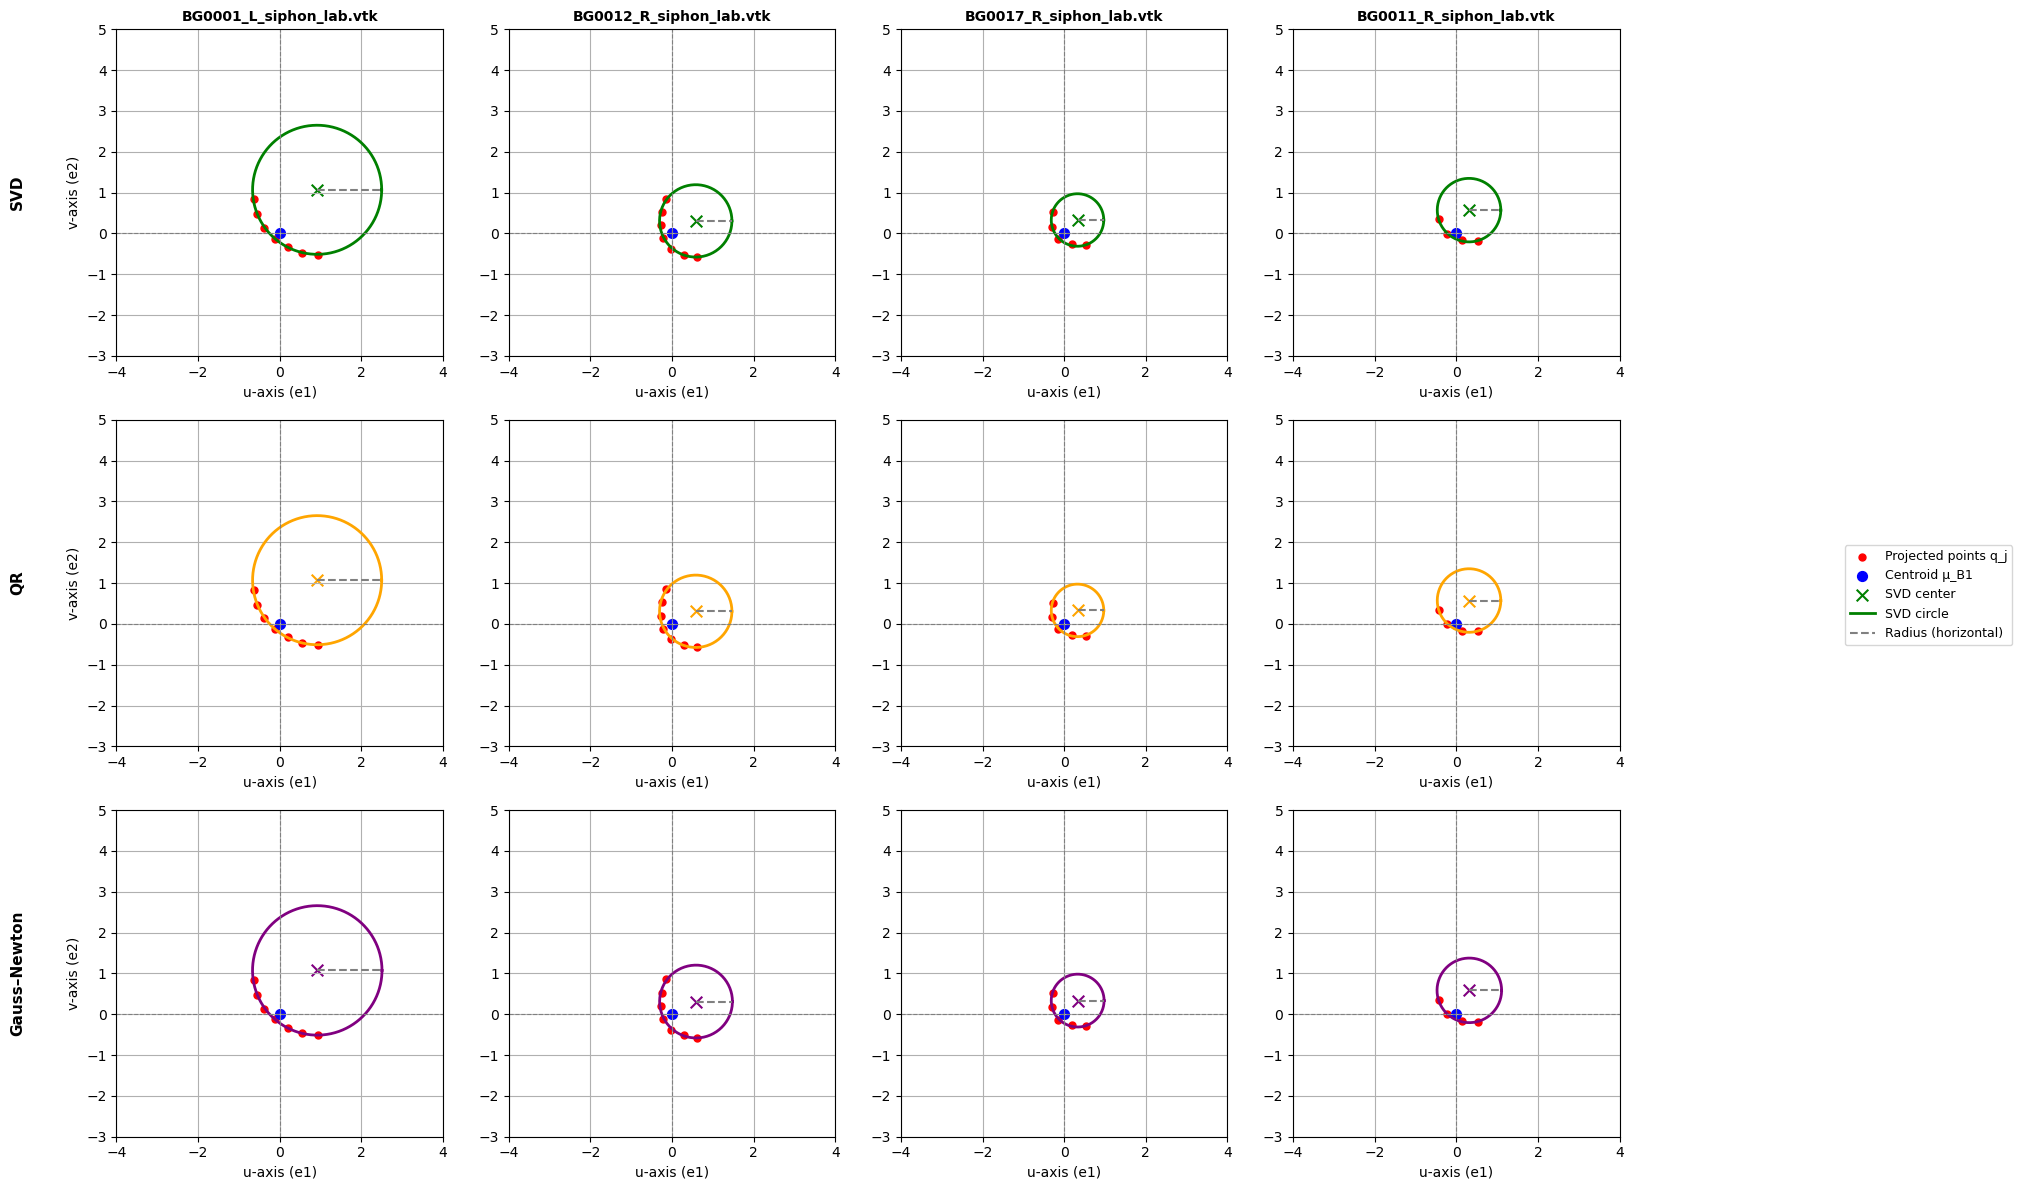

In [53]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np
import os

# === Parameters ===
DROP_RATIO = 0.8

# === Input datasets ===
input_paths = [
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk", # U type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0012_R_siphon_lab.vtk", # V type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0017_R_siphon_lab.vtk", # C type
    r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0011_R_siphon_lab.vtk"  # U type
]

# === 每个病例的法向量方向控制 ===
# True → 翻转法向量方向
FLIP_NORMALS = {
    "BG0001_L": False,
    "BG0012_R": False,
    "BG0017_R": False,
    "BG0011_R": True
}

# === Algebraic circle fitting (SVD-based lstsq) ===
def fit_circle_algebraic(points_2d):
    x = points_2d[:, 0]
    y = points_2d[:, 1]
    A = np.c_[x, y, np.ones_like(x)]
    b = -(x**2 + y**2)
    coeff, _, _, _ = np.linalg.lstsq(A, b, rcond=None)  # SVD-based
    a, b_, c = coeff
    xc = -a / 2
    yc = -b_ / 2
    r = np.sqrt((a**2 + b_**2) / 4 - c)
    return xc, yc, r

# === QR decomposition least-squares ===
def fit_circle_qr(points_2d):
    x = points_2d[:, 0]
    y = points_2d[:, 1]
    A = np.c_[x, y, np.ones_like(x)]
    b = -(x**2 + y**2)
    Q, R = np.linalg.qr(A)
    coeff = np.linalg.solve(R, Q.T @ b)         # 解 Rθ = Qᵀb
    a, b_, c = coeff
    xc = -a / 2
    yc = -b_ / 2
    r = np.sqrt((a**2 + b_**2) / 4 - c)
    return xc, yc, r

# === Gauss–Newton refinement ===
def fit_circle_refine(points_2d, init_params=None, max_iter=100, tol=1e-10, lam=1e-6):
    x = points_2d[:, 0].astype(float)
    y = points_2d[:, 1].astype(float)
    if init_params is None:
        xc = np.mean(x); yc = np.mean(y)
        r = np.mean(np.sqrt((x - xc)**2 + (y - yc)**2))
    else:
        xc, yc, r = init_params

    last_cost = np.inf
    for _ in range(max_iter):
        Ri = np.sqrt((x - xc)**2 + (y - yc)**2)
        Ri = np.where(Ri < 1e-12, 1e-12, Ri)    # 避免除零
        residuals = Ri - r
        J = np.c_[ -(x - xc) / Ri, -(y - yc) / Ri, -np.ones_like(Ri) ]
        H = J.T @ J + lam * np.eye(3)
        g = J.T @ residuals
        delta = -np.linalg.solve(H, g)
        xc += delta[0]; yc += delta[1]; r += delta[2]
        cost = np.mean(residuals**2)
        if abs(last_cost - cost) < tol or np.linalg.norm(delta) < tol:
            break
        last_cost = cost
    return xc, yc, r

# === 自适应高曲率段提取 ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    threshold = drop_ratio * max_val
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx - 1] >= threshold:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx + 1] >= threshold:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx + 1]
    return seg_pts, max_idx, left_idx, right_idx, max_val, threshold


# === Figure setup (3×4) ===
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
per_case_data = []

for col, path in enumerate(input_paths):
    centerline = pv.read(path)
    points = centerline.points
    labels = centerline["lab"]
    curvature = centerline["curvature"]

    # --- B1 段 ---
    bend1_pts = points[labels == 1]
    bend1_curv = curvature[labels == 1]
    seg_pts, max_idx, left_idx, right_idx, max_val, threshold = extract_adaptive_segment(bend1_pts, bend1_curv)

    # --- 拟合平面 ---
    mean_pt = np.mean(seg_pts, axis=0)
    centered = seg_pts - mean_pt
    cov = np.dot(centered.T, centered)
    eigvals, eigvecs = np.linalg.eigh(cov)
    n_B1 = eigvecs[:, np.argmin(eigvals)]
    n_B1 /= np.linalg.norm(n_B1)

    # --- 法向量翻转控制 ---
    case_id = os.path.basename(path).split("_siphon")[0]
    if FLIP_NORMALS.get(case_id, False):
        n_B1 = -n_B1

    # --- 投影到平面 ---
    proj_points_3d = np.array([p - np.dot(p - mean_pt, n_B1) * n_B1 for p in seg_pts])

    # --- 局部坐标系 ---
    temp = np.array([1, 0, 0]) if abs(n_B1[0]) < 0.9 else np.array([0, 1, 0])
    e1 = np.cross(n_B1, temp); e1 /= np.linalg.norm(e1)
    e2 = np.cross(n_B1, e1);  e2 /= np.linalg.norm(e2)
    u_v_coords = np.array([[np.dot(q - mean_pt, e1), np.dot(q - mean_pt, e2)] for q in proj_points_3d])

    # 三种拟合
    xc_alg, yc_alg, r_alg = fit_circle_algebraic(u_v_coords)
    xc_qr,  yc_qr,  r_qr  = fit_circle_qr(u_v_coords)
    xc_ref, yc_ref, r_ref = fit_circle_refine(u_v_coords, (xc_alg, yc_alg, r_alg))

    print(f"\n=== {os.path.basename(path)} ===")
    print(f"[SVD          ] Center=({xc_alg:.6f}, {yc_alg:.6f}), Radius={r_alg:.6f}")
    print(f"[QR           ] Center=({xc_qr :.6f}, {yc_qr :.6f}), Radius={r_qr :.6f}")
    print(f"[Gauss–Newton ] Center=({xc_ref:.6f}, {yc_ref:.6f}), Radius={r_ref:.6f}")

    per_case_data.append({
        "name": os.path.basename(path),
        "u_v": u_v_coords,
        "alg": (xc_alg, yc_alg, r_alg),
        "qr":  (xc_qr,  yc_qr,  r_qr),
        "ref": (xc_ref, yc_ref, r_ref)
    })


# === 绘图（3×4）：SVD / QR / Gauss–Newton ===
theta = np.linspace(0, 2*np.pi, 200)
xlim = (-4, 4)
ylim = (-3, 5)

for col, data in enumerate(per_case_data):
    name = data["name"]
    u_v = data["u_v"]
    (xc_alg, yc_alg, r_alg) = data["alg"]
    (xc_qr,  yc_qr,  r_qr ) = data["qr"]
    (xc_ref, yc_ref, r_ref) = data["ref"]

    circles = [
        ("SVD", "green",  xc_alg, yc_alg, r_alg),
        ("QR", "orange", xc_qr,  yc_qr,  r_qr ),
        ("Gauss–Newton", "purple", xc_ref, yc_ref, r_ref),
    ]

    for row, (label, color, xc, yc, r) in enumerate(circles):
        ax = axes[row, col]
        ax.scatter(u_v[:, 0], u_v[:, 1], s=25, color="red", label="Projected points q_j")
        ax.scatter(0, 0, s=50, color="blue", label="Centroid μ_B1")
        ax.scatter(xc, yc, s=70, color=color, marker="x", label=f"{label} center")
        ax.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), color=color, linewidth=2, label=f"{label} circle")
        ax.plot([xc, xc + r], [yc, yc], color="gray", linestyle="--", label="Radius (horizontal)")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("u-axis (e1)")
        if col == 0:
            ax.set_ylabel("v-axis (e2)")
            ax.text(-0.28, 0.5, label, fontsize=11, fontweight="bold",
                    rotation=90, va="center", ha="right", transform=ax.transAxes)
        if row == 0:
            ax.set_title(name, fontsize=10, fontweight="bold")
        ax.grid(True)
        ax.set_aspect('equal', adjustable='box')
        ax.axhline(0, color="gray", linewidth=0.8, linestyle='--')
        ax.axvline(0, color="gray", linewidth=0.8, linestyle='--')

# === 外部图例 ===
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, frameon=True)

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()


BG0001_L        | 0.2689 | 0.2766 | 0.0759 | 0.0497 | 0.0308 | 0.0188 | 0.0081 | 0.0073 |   --- 
BG0001_R        | 0.2483 | 0.1466 | 0.0734 | 0.0478 | 0.0325 | 0.0223 | 0.0112 | 0.0081 |   --- 
BG0004_L        | 0.4889 | 0.0853 | 0.0514 | 0.0263 | 0.0174 | 0.0125 | 0.0060 | 0.0043 |   --- 
BG0004_R        | 0.1484 | 0.0851 | 0.0337 | 0.0222 | 0.0215 | 0.0137 | 0.0048 |   ---  |   --- 
BG0006_L        | 0.2739 | 0.1449 | 0.1043 | 0.0665 | 0.0481 | 0.0335 | 0.0184 | 0.0048 |   --- 
BG0006_R        | 1.1357 | 0.1104 | 0.0441 | 0.0210 | 0.0164 | 0.0135 | 0.0109 | 0.0052 |   --- 
BG0007_L        | 0.3341 | 0.1624 | 0.1299 | 0.0804 | 0.0778 | 0.0424 | 0.0134 | 0.0134 |   --- 
BG0007_R        | 0.3957 | 0.1516 | 0.0813 | 0.0508 | 0.0247 | 0.0207 | 0.0158 | 0.0059 |   --- 
BG0008_L        | 0.1398 | 0.1388 | 0.1438 | 0.1340 | 0.0907 | 0.0554 | 0.0337 | 0.0210 | 0.0028
BG0008_R        | 0.2075 | 0.1662 | 0.0897 | 0.0429 | 0.0310 | 0.0167 | 0.0105 | 0.0068 | 0.0033
BG0009_L        | 0.2907 | 0.1

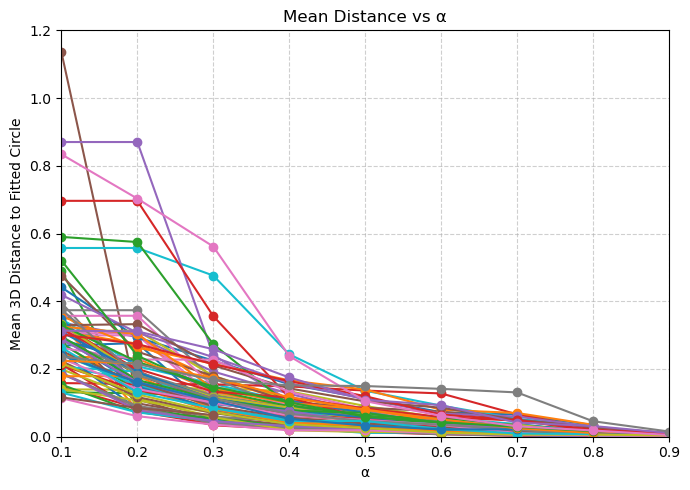

In [91]:
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

# === 参数 ===
DATA_DIR = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)"
DROP_RATIOS = np.arange(0.1, 1.0, 0.1)

# === 工具函数 ===
def extract_adaptive_segment(pts, curv, drop_ratio):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    thr = drop_ratio * max_val
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx - 1] >= thr:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx + 1] >= thr:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx + 1]
    return seg_pts, max_idx, max_val, thr

def fit_circle(u_v):
    x = u_v[:, 0]
    y = u_v[:, 1]
    A = np.c_[x, y, np.ones_like(x)]
    b = -(x**2 + y**2)
    coeff, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    a, b_, c = coeff
    xc, yc = -a / 2, -b_ / 2
    r = np.sqrt((a**2 + b_**2) / 4 - c)
    return xc, yc, r

def calc_mean_distance(seg_pts):
    # 平面拟合
    mean_pt = np.mean(seg_pts, axis=0)
    X = seg_pts - mean_pt
    C = X.T @ X
    eigvals, eigvecs = np.linalg.eigh(C)
    n = eigvecs[:, np.argmin(eigvals)] / np.linalg.norm(eigvecs[:, np.argmin(eigvals)])

    # 局部平面坐标系
    tmp = np.array([1, 0, 0]) if abs(n[0]) < 0.9 else np.array([0, 1, 0])
    e1 = np.cross(n, tmp); e1 /= np.linalg.norm(e1)
    e2 = np.cross(n, e1);  e2 /= np.linalg.norm(e2)

    # 投影 + 拟合圆
    proj_pts = np.array([p - np.dot(p - mean_pt, n) * n for p in seg_pts])
    u_v = np.array([[np.dot(q - mean_pt, e1), np.dot(q - mean_pt, e2)] for q in proj_pts])
    xc, yc, r = fit_circle(u_v)

    # 三维点到圆的距离
    circle_center = mean_pt + xc * e1 + yc * e2
    h = (seg_pts - circle_center) @ n
    proj_pts = seg_pts - np.outer(h, n)
    r_i = np.linalg.norm(proj_pts - circle_center, axis=1)
    dist3d = np.sqrt((r_i - r)**2 + h**2)

    return dist3d.mean(), dist3d.max()

# === 主程序 ===
files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".vtk")]
results = {}

for file in files:
    name = os.path.basename(file).replace("_siphon_lab.vtk", "")
    #print(f"\nProcessing {name} ...")
    cl = pv.read(file)
    pts_all = cl.points
    lab = cl["lab"]
    curv = cl["curvature"]

    # 只取 B1 段（如果没有B1则跳过）
    if 1 not in np.unique(lab):
        print("  [Skip] no B1 label")
        continue
    pts = pts_all[lab == 1]
    k = curv[lab == 1]

    mean_vals = []
    for ratio in DROP_RATIOS:
        seg_pts, _, _, _ = extract_adaptive_segment(pts, k, ratio)
        if len(seg_pts) < 5:
            mean_vals.append(np.nan)
            continue
        mean_d, _ = calc_mean_distance(seg_pts)
        mean_vals.append(mean_d)
    results[name] = mean_vals

# === 输出表格 ===
ratios_str = " | ".join([f"{r:.1f}" for r in DROP_RATIOS])
#print(f"\n{'Case':<15} | {ratios_str}")
#print("-" * (17 + 7 * len(DROP_RATIOS)))
for name, vals in results.items():
    vals_str = " | ".join([f"{v:.4f}" if not np.isnan(v) else "  --- " for v in vals])
    print(f"{name:<15} | {vals_str}")

# === 可视化 ===
plt.figure(figsize=(7,5))
for name, vals in results.items():
    plt.plot(DROP_RATIOS, vals, marker='o', label=name)
plt.xlabel('α')
plt.xlim(0.1, 0.9)
plt.ylabel('Mean 3D Distance to Fitted Circle')
plt.ylim(0,1.2)
plt.title('Mean Distance vs α')
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


加载成功: (78, 6)
              Filename  Best_Drop_B1  Best_Drop_B2   CR_B1   CR_B2      β
0  BG0001_L_siphon_lab           0.8           0.7  1.6786  3.8594  45.10
1  BG0001_R_siphon_lab           0.9           0.9  1.0892  3.8655  38.63
2  BG0004_L_siphon_lab           0.8           0.8  1.6618  3.8871  33.36
3  BG0004_R_siphon_lab           0.8           0.8  1.4864  2.5933  48.49
4  BG0006_L_siphon_lab           0.9           0.9  1.5081  1.9186  45.24

结果已保存到: D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\2_Siphon information\6_Siphon_B1B2_MeanDist.xlsx
                  Case  MeanDist_B1  MeanDist_B2  MaxDist_B1  MaxDist_B2
0  BG0001_L_siphon_lab     0.006752     0.010832    0.015880    0.028509
1  BG0001_R_siphon_lab     0.003395     0.002291    0.005277    0.004442
2  BG0004_L_siphon_lab     0.004332     0.003481    0.007973    0.009058
3  BG0004_R_siphon_lab     0.002033     0.010165    0.003145    0.015212
4  BG0006_L_siphon_lab     0.000462     0.003975    0.000697    0.0

C:\Users\Harujane\AppData\Local\Temp\ipykernel_17488\650451777.py:125: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Harujane\AppData\Local\Temp\ipykernel_17488\650451777.py:125: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Harujane\AppData\Local\Temp\ipykernel_17488\650451777.py:125: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Harujane\AppData\Local\Temp\ipykernel_17488\650451777.py:125: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Harujane\AppData\Local\Temp\ipykernel_17488\650451777.py:125: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Harujane\AppData\Local\Temp\ipykernel_17488\650451777.py:125: UserWarni

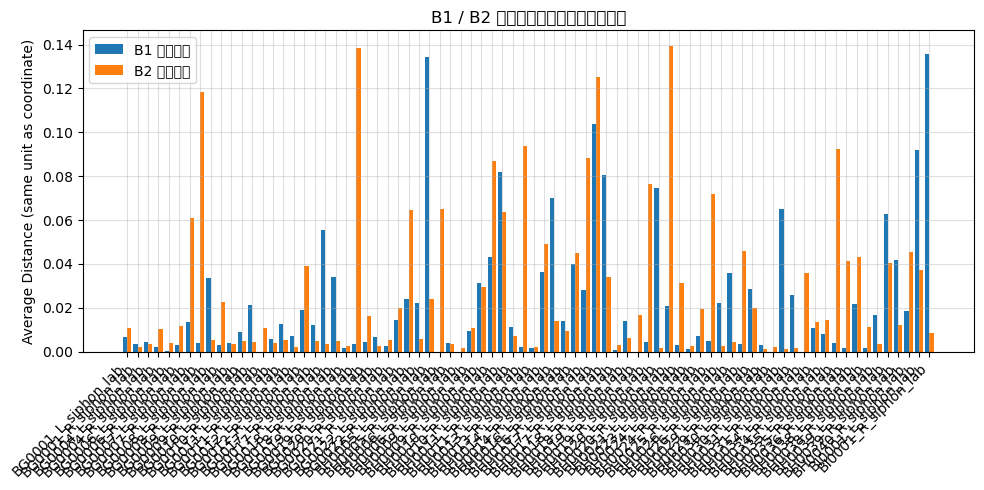

In [93]:
import os
import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt

# === 路径设定 ===
base_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)"
xlsx_path = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\2_Siphon information\5_Siphon_Geometry_BestDrop.xlsx"

# === 读取最优阈值表 ===
df = pd.read_excel(xlsx_path)
# 假设列名为 Case, Best_Drop_B1, Best_Drop_B2
print("加载成功:", df.shape)
print(df.head())

# === 提取高曲率段函数 ===
def extract_segment(pts, k, drop_ratio):
    i_max = np.argmax(k)
    k_max = k[i_max]
    thr = drop_ratio * k_max
    L = R = i_max
    while L > 0 and k[L - 1] >= thr:
        L -= 1
    while R < len(k) - 1 and k[R + 1] >= thr:
        R += 1
    return pts[L:R + 1], i_max, L, R, k_max, thr

# === 平面拟合 + 投影 + 拟合圆 ===
def fit_circle_3d_distance(seg_pts):
    # 平面拟合
    mean_pt = np.mean(seg_pts, axis=0)
    centered = seg_pts - mean_pt
    cov = centered.T @ centered
    eigvals, eigvecs = np.linalg.eigh(cov)
    n = eigvecs[:, np.argmin(eigvals)]
    n /= np.linalg.norm(n)

    # 投影到平面
    proj_pts = np.array([p - np.dot(p - mean_pt, n) * n for p in seg_pts])
    tmp = np.array([1, 0, 0]) if abs(n[0]) < 0.9 else np.array([0, 1, 0])
    e1 = np.cross(n, tmp); e1 /= np.linalg.norm(e1)
    e2 = np.cross(n, e1);  e2 /= np.linalg.norm(e2)
    u_v = np.array([[np.dot(p - mean_pt, e1), np.dot(p - mean_pt, e2)] for p in proj_pts])

    # 圆拟合（代数法）
    x, y = u_v[:, 0], u_v[:, 1]
    A = np.c_[x, y, np.ones_like(x)]
    b = -(x**2 + y**2)
    coeff, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    a, b_, c = coeff
    xc, yc = -a / 2, -b_ / 2
    r = np.sqrt((a**2 + b_**2) / 4 - c)

    # 圆心从局部系还原到3D
    circle_center = mean_pt + xc * e1 + yc * e2

    # 计算3D点到圆的距离
    dist_all = []
    for p in seg_pts:
        vec = p - circle_center
        # 投影到圆平面
        proj = vec - np.dot(vec, n) * n
        d_plane = np.linalg.norm(proj)
        dist_all.append(abs(d_plane - r))
    return np.mean(dist_all), np.max(dist_all)

# === 主循环 ===
results = []
vtk_files = [f for f in os.listdir(base_dir) if f.endswith(".vtk")]

for idx, row in df.iterrows():
    case = str(row["Filename"])
    drop_b1 = row["Best_Drop_B1"]
    drop_b2 = row["Best_Drop_B2"]

    file_match = [f for f in vtk_files if case in f]
    if not file_match:
        print(f"[跳过] 未找到 {case}")
        continue
    path = os.path.join(base_dir, file_match[0])
    mesh = pv.read(path)

    points = mesh.points
    labels = mesh["lab"]
    curv = mesh["curvature"]

    # B1
    pts_b1 = points[labels == 1]
    k_b1 = curv[labels == 1]
    seg_b1, _, _, _, _, _ = extract_segment(pts_b1, k_b1, drop_b1)
    mean_b1, max_b1 = fit_circle_3d_distance(seg_b1)

    # B2
    pts_b2 = points[labels == 2]
    k_b2 = curv[labels == 2]
    seg_b2, _, _, _, _, _ = extract_segment(pts_b2, k_b2, drop_b2)
    mean_b2, max_b2 = fit_circle_3d_distance(seg_b2)

    results.append({
        "Case": case,
        "MeanDist_B1": mean_b1,
        "MeanDist_B2": mean_b2,
        "MaxDist_B1": max_b1,
        "MaxDist_B2": max_b2
    })

# === 汇总输出 ===
out_df = pd.DataFrame(results)
out_path = os.path.join(os.path.dirname(xlsx_path), "6_Siphon_B1B2_MeanDist.xlsx")
out_df.to_excel(out_path, index=False)
print(f"\n结果已保存到: {out_path}")
print(out_df.head())

# === 可视化 ===
plt.figure(figsize=(10, 5))
x = np.arange(len(out_df))
plt.bar(x - 0.2, out_df["MeanDist_B1"], width=0.4, label="B1 平均距离")
plt.bar(x + 0.2, out_df["MeanDist_B2"], width=0.4, label="B2 平均距离")
plt.xticks(x, out_df["Case"], rotation=45, ha='right')
plt.ylabel("Average Distance (same unit as coordinate)")
plt.title("B1 / B2 平均距离（各症例最优阈值）")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()
